<a href="https://colab.research.google.com/github/thaisja/projeto-aplicado-netflix/blob/main/01_NETFLIX_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# %%
!pip -q install pyarrow fastparquet tqdm

import os, gc, math, random, sys, textwrap, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

pd.set_option("display.max_columns", 50)
pd.set_option("display.float_format", lambda x: f"{x:,.4f}")
sns.set()
SEED = 42
random.seed(SEED); np.random.seed(SEED)



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 13.9 MB/s eta 0:00:00


In [19]:
from google.colab import drive
drive.mount('/content/drive')

DATA_DIR = "/content/drive/MyDrive/MACKENZIE/4S Ciência de Dados"

FILES = [
    f"{DATA_DIR}/combined_data_1.txt",
    f"{DATA_DIR}/combined_data_2.txt",
    f"{DATA_DIR}/combined_data_3.txt",
    f"{DATA_DIR}/combined_data_4.txt"
]
import os
for f in FILES:
    print(f, "->", os.path.exists(f))



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/MACKENZIE/4S Ciência de Dados/combined_data_1.txt -> True
/content/drive/MyDrive/MACKENZIE/4S Ciência de Dados/combined_data_2.txt -> True
/content/drive/MyDrive/MACKENZIE/4S Ciência de Dados/combined_data_3.txt -> True
/content/drive/MyDrive/MACKENZIE/4S Ciência de Dados/combined_data_4.txt -> True


In [18]:
!pip -q install pyarrow fastparquet tqdm

import random, pandas as pd, numpy as np
from tqdm import tqdm
import gc

SAMPLE_RATE = 0.002
MAX_ROWS_PER_FILE = None
SEED = 42
random.seed(SEED)

CACHE_PARQUET = "/content/netflix_all_sample.parquet"
CACHE_PARQUET_DRIVE = f"{DATA_DIR}/netflix_all_sample.parquet"

def iter_netflix_file(path, sample_rate=1.0, max_rows=None, seed=SEED):
    rng = random.Random(seed)
    movie_id = None
    out = 0
    with open(path, "r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            if line.endswith(":"):
                movie_id = int(line[:-1])
                continue
            try:
                user_id, rating, dt = line.split(",")
                if max_rows is not None and out >= max_rows:
                    break
                if sample_rate < 1.0 and rng.random() > sample_rate:
                    continue
                yield (int(user_id), movie_id, float(rating), dt)
                out += 1
            except:
                continue

def load_all(files, sample_rate=SAMPLE_RATE, max_rows_per_file=MAX_ROWS_PER_FILE):
    rows = []
    for p in files:
        print("Lendo:", p)
        for tup in tqdm(iter_netflix_file(p, sample_rate=sample_rate, max_rows=max_rows_per_file)):
            rows.append(tup)
    df = pd.DataFrame(rows, columns=["user_id","movie_id","rating","date"])
    df["user_id"]  = df["user_id"].astype("int32")
    df["movie_id"] = df["movie_id"].astype("int32")
    df["rating"]   = df["rating"].astype("float32")
    df["date"]     = pd.to_datetime(df["date"], format="%Y-%m-%d", errors="coerce")
    return df
try:
    import os
    if os.path.exists(CACHE_PARQUET):
        df = pd.read_parquet(CACHE_PARQUET)
        print("Carregado do cache local:", CACHE_PARQUET, df.shape)
    elif os.path.exists(CACHE_PARQUET_DRIVE):
        df = pd.read_parquet(CACHE_PARQUET_DRIVE)
        print("Carregado do cache no Drive:", CACHE_PARQUET_DRIVE, df.shape)
    else:
        df = load_all(FILES, sample_rate=SAMPLE_RATE, max_rows_per_file=MAX_ROWS_PER_FILE)
        df.to_parquet(CACHE_PARQUET, index=False)
        df.to_parquet(CACHE_PARQUET_DRIVE, index=False)
        print("Amostra combinada salva em:", CACHE_PARQUET, "e", CACHE_PARQUET_DRIVE, df.shape)
except Exception as e:
    print("Erro ao carregar/criar cache:", e)

df.head()


Carregado do cache local: /content/netflix_all_sample.parquet (200016, 4)


,user_id,movie_id,rating,date
0,831869,1,4.0000,2005-06-02
1,1562707,1,1.0000,2005-07-25
2,1133763,1,3.0000,2005-05-15
3,2143500,3,3.0000,2004-12-31
4,1334851,3,4.0000,2005-08-22


In [20]:
def memory_mb(df):
    return df.memory_usage(deep=True).sum() / (1024**2)

print("Shape:", df.shape, "| Memória (MB):", round(memory_mb(df), 2))
print("Período:", df["date"].min(), "->", df["date"].max())
print("\nAusentes:\n", df.isna().sum())
print("\nDuplicatas exatas:", df.duplicated().sum())


Shape: (200016, 4) | Memória (MB): 3.82
Período: 1999-12-12 00:00:00 -> 2005-12-31 00:00:00

Ausentes:
 user_id     0
movie_id    0
rating      0
date        0
dtype: int64

Duplicatas exatas: 0


count   200,016.0000
mean          3.6062
std           1.0834
min           1.0000
25%           3.0000
50%           4.0000
75%           4.0000
max           5.0000
Name: rating, dtype: float64


,rating,count,share
0,1.0000,9038,0.0452
1,2.0000,20242,0.1012
2,3.0000,57238,0.2862
3,4.0000,67426,0.3371
4,5.0000,46072,0.2303


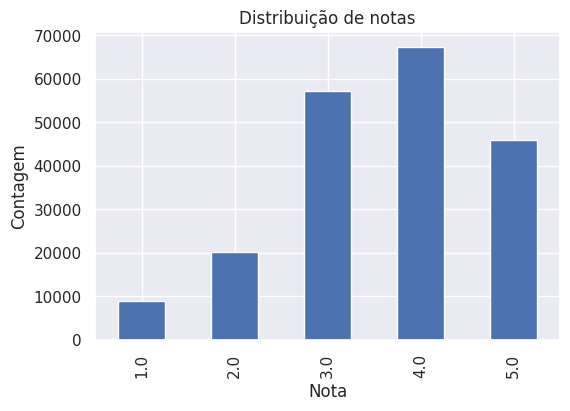

In [21]:
print(df["rating"].describe())

# distribuição (tabela)
rating_counts = df["rating"].value_counts().sort_index()
display(pd.DataFrame({"rating": rating_counts.index, "count": rating_counts.values,
                      "share": (rating_counts/len(df)).values}))

# gráfico
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
df["rating"].value_counts().sort_index().plot(kind="bar")
plt.title("Distribuição de notas")
plt.xlabel("Nota"); plt.ylabel("Contagem")
plt.show()


Usuários únicos: 127620 | Itens únicos: 11554


,n_ratings_user
count,"127,620.0000"
mean,1.5673
std,1.0609
min,1.0000
25%,1.0000
50%,1.0000
75%,2.0000
max,28.0000


,n_ratings_item
count,"11,554.0000"
mean,17.3114
std,40.4647
min,1.0000
25%,1.0000
50%,3.0000
75%,12.0000
max,407.0000


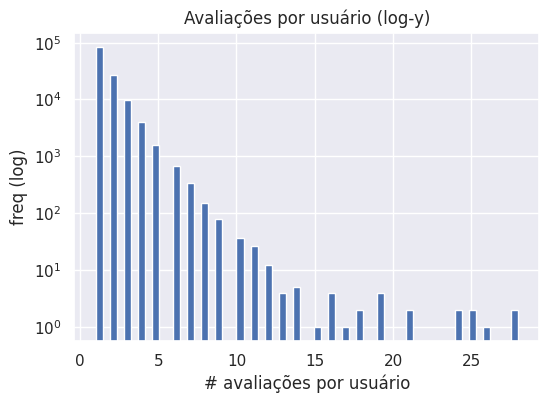

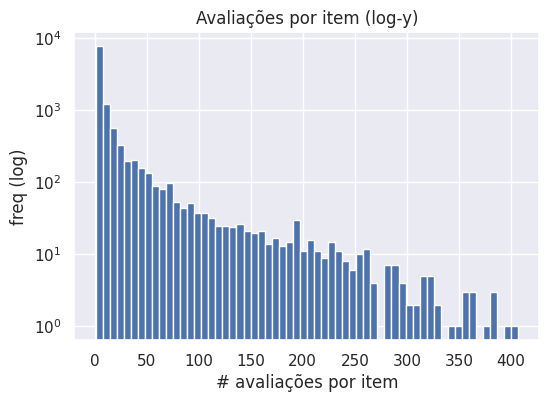

In [8]:
user_activity = df.groupby("user_id", as_index=False).size().rename(columns={"size":"n_ratings_user"})
item_pop     = df.groupby("movie_id", as_index=False).size().rename(columns={"size":"n_ratings_item"})

print("Usuários únicos:", user_activity.shape[0], "| Itens únicos:", item_pop.shape[0])
display(user_activity["n_ratings_user"].describe())
display(item_pop["n_ratings_item"].describe())

plt.figure(figsize=(6,4))
plt.hist(user_activity["n_ratings_user"], bins=60)
plt.yscale("log"); plt.title("Avaliações por usuário (log-y)")
plt.xlabel("# avaliações por usuário"); plt.ylabel("freq (log)")
plt.show()

plt.figure(figsize=(6,4))
plt.hist(item_pop["n_ratings_item"], bins=60)
plt.yscale("log"); plt.title("Avaliações por item (log-y)")
plt.xlabel("# avaliações por item"); plt.ylabel("freq (log)")
plt.show()


In [9]:
n_obs = len(df)
n_users = user_activity.shape[0]
n_items = item_pop.shape[0]
density = n_obs / (n_users * n_items)
print(f"Interações: {n_obs:,} | Usuários: {n_users:,} | Itens: {n_items:,}")
print(f"Densidade (sparsidade): {density:.8f} -> matriz extremamente esparsa")


Interações: 200,016 | Usuários: 127,620 | Itens: 11,554
Densidade (sparsidade): 0.00013565 -> matriz extremamente esparsa


In [10]:
top_items = (df.groupby("movie_id")["rating"]
               .agg(n_ratings="count", mean_rating="mean")
               .sort_values("n_ratings", ascending=False)
               .head(15))
display(top_items)

top_users = (df.groupby("user_id")["rating"]
               .agg(n_ratings="count", mean_rating="mean")
               .sort_values("n_ratings", ascending=False)
               .head(15))
display(top_users)

MIN_RATINGS = 200
best_items = (df.groupby("movie_id")["rating"]
                .agg(n_ratings="count", mean_rating="mean")
                .query("n_ratings >= @MIN_RATINGS")
                .sort_values("mean_rating", ascending=False)
                .head(15))
display(best_items)


,n_ratings,mean_rating
movie_id,,
5317,407,3.4079
15124,400,3.6800
1905,383,4.0339
6287,380,3.8868
15205,380,3.4237
12470,378,3.3704
14313,365,3.8767
9340,364,3.4258
15582,363,3.4683


,n_ratings,mean_rating
user_id,,
305344,28,1.6786
1664010,28,4.2143
2439493,26,1.1538
2118461,25,4.0400
1314869,25,2.8800
387418,24,1.8333
1932594,24,2.6667
2056022,21,2.2381
1639792,21,1.2857


,n_ratings,mean_rating
movie_id,,
14240,235,4.5532
10042,228,4.5175
14550,271,4.5018
12293,214,4.5000
2452,287,4.4564
11521,261,4.4215
3962,313,4.4089
6974,221,4.3710
10947,245,4.3469


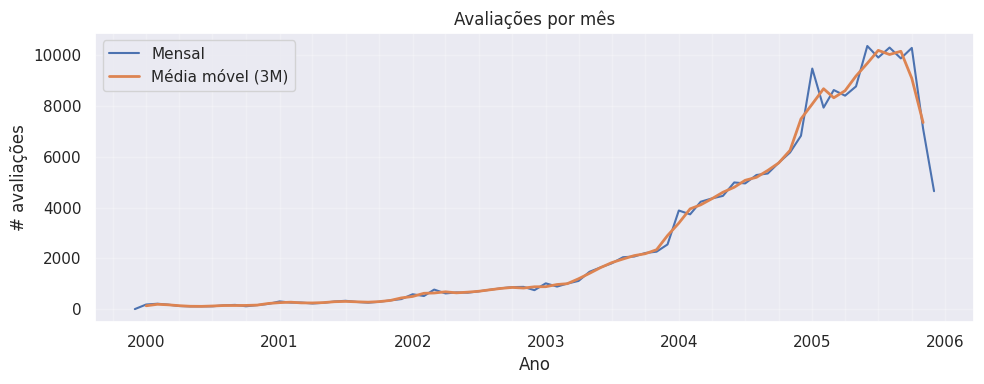

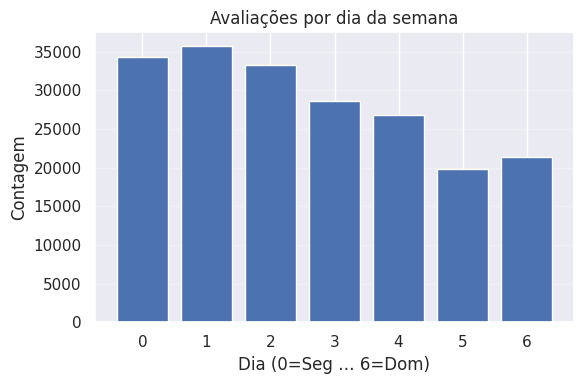

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

df["month"] = df["date"].values.astype("datetime64[M]")

ts_month = (df.groupby("month", as_index=True)
              .size()
              .rename("n_ratings")
              .sort_index())

last_month = ts_month.index.max()
in_last = (df["month"] == last_month)
n_unique_days = df.loc[in_last, "date"].dt.day.nunique()
if n_unique_days < 25:
    ts_month = ts_month.iloc[:-1]

fig, ax = plt.subplots(figsize=(10,4))
ax.plot(ts_month.index, ts_month.values, linewidth=1.5, label="Mensal")

roll3 = ts_month.rolling(window=3, center=True).mean()
ax.plot(roll3.index, roll3.values, linewidth=2.0, label="Média móvel (3M)")

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=[1,4,7,10]))

ax.set_title("Avaliações por mês")
ax.set_xlabel("Ano")
ax.set_ylabel("# avaliações")
ax.grid(True, which="both", alpha=0.25)
ax.legend()
plt.tight_layout()
plt.show()

df["weekday"] = df["date"].dt.weekday
wk = df["weekday"].value_counts().sort_index()

plt.figure(figsize=(6,4))
plt.bar(wk.index, wk.values)
plt.title("Avaliações por dia da semana")
plt.xlabel("Dia (0=Seg … 6=Dom)")
plt.ylabel("Contagem")
plt.grid(True, axis="y", alpha=0.25)
plt.tight_layout()
plt.show()


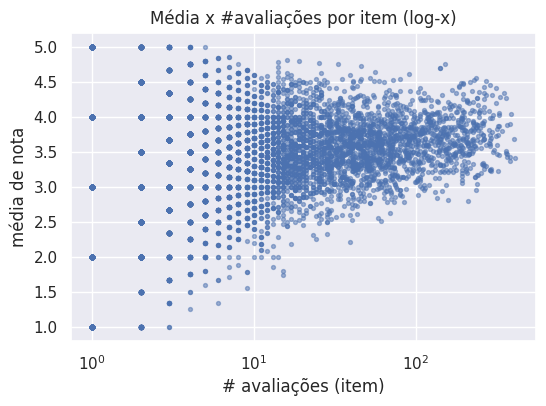

In [22]:
tmp = (df.groupby("movie_id")["rating"]
         .agg(n_ratings="count", mean_rating="mean"))

plt.figure(figsize=(6,4))
plt.scatter(tmp["n_ratings"], tmp["mean_rating"], s=8, alpha=0.5)
plt.xscale("log")
plt.title("Média x #avaliações por item (log-x)")
plt.xlabel("# avaliações (item)"); plt.ylabel("média de nota")
plt.show()


In [15]:
u_cold = (user_activity["n_ratings_user"] <= 5).mean()
i_cold = (item_pop["n_ratings_item"] <= 5).mean()
print(f"% usuários com <=5 avaliações: {100*u_cold:.2f}%")
print(f"% itens com <=5 avaliações:   {100*i_cold:.2f}%")


% usuários com <=5 avaliações: 98.94%
% itens com <=5 avaliações:   61.30%


In [24]:
before = len(df)
df = df.dropna(subset=["date"])
df = df.sort_values(["user_id","movie_id","date"])

dup_count = df.duplicated(subset=["user_id","movie_id","date","rating"]).sum()
df = df[~df.duplicated(subset=["user_id","movie_id","date","rating"])].reset_index(drop=True)
print("Removidas (NaT + duplicatas):", before - len(df), "| duplicatas:", dup_count)

MIN_U, MIN_I = 5, 5
u_keep = df["user_id"].map(df["user_id"].value_counts()) >= MIN_U
i_keep = df["movie_id"].map(df["movie_id"].value_counts()) >= MIN_I
df_small = df[u_keep & i_keep].reset_index(drop=True)

print("Shape total:", before, "-> após limpeza:", df.shape, "-> POC:", df_small.shape)

OUT_PARQUET = "/content/netflix_poc_clean.parquet"
OUT_PARQUET_DRIVE = f"{DATA_DIR}/netflix_poc_clean.parquet"
df_small.to_parquet(OUT_PARQUET, index=False)
df_small.to_parquet(OUT_PARQUET_DRIVE, index=False)
print("POC salva em:", OUT_PARQUET, "e", OUT_PARQUET_DRIVE)
gc.collect()


Removidas (NaT + duplicatas): 0 | duplicatas: 0
Shape total: 200016 -> após limpeza: (200016, 6) -> POC: (15535, 6)
POC salva em: /content/netflix_poc_clean.parquet e /content/drive/MyDrive/MACKENZIE/4S Ciência de Dados/netflix_poc_clean.parquet


21127

In [25]:
df_small = df_small.sort_values(["user_id","date"])
last_idx = df_small.groupby("user_id").tail(1).index
val = df_small.loc[last_idx]
train = df_small.drop(last_idx)

print("Train:", train.shape, "| Val:", val.shape)
print("Período Train:", train["date"].min(), "->", train["date"].max())
print("Período Val:",   val["date"].min(),   "->", val["date"].max())


Train: (12582, 6) | Val: (2953, 6)
Período Train: 2000-01-06 00:00:00 -> 2005-12-31 00:00:00
Período Val: 2000-05-14 00:00:00 -> 2005-12-31 00:00:00
